In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sts
from tqdm import tqdm
from sklearn import metrics
from datetime import timedelta
from numpy import linalg
import statsmodels

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_acf_pacf(timeseries):
    """
    Функция, отображающая график временного ряда, 
    автокорреляционную функцию(ACF)
    и частную автокорреляционную функцию(PACF).
    """
    fig = plt.figure(figsize=(16,20))
    
    ax0 = fig.add_subplot(311)
    timeseries.plot(ax=ax0)
    ax0.set_title('График временного ряда')
    ax0.set_xlabel('Дата')
    ax0.set_ylabel('Количество новых заболеваний')
    
    ax1 = fig.add_subplot(312)
    fig = sm.graphics.tsa.plot_acf(timeseries, ax=ax1)
    ax1.set_title('Автокорреляционная функция')
    
    ax2 = fig.add_subplot(313)
    fig = sm.graphics.tsa.plot_pacf(timeseries, ax=ax2)
    ax2.set_title('Частная автокорреляционная функция')

def adf_test(timeseries):
    pvalue = sm.tsa.stattools.adfuller(timeseries)[1]
    print("Критерий Дики-Фуллера: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен, нужно большее d")
    else:
        print("Ряд стационарен, d подходит")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='c')[1]
    print("Критерий Дики-Фуллера с константой: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ct')[1]
    print("Критерий Дики-Фуллера с константой и трендом: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ctt')[1]
    print("Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='nc')[1]
    print("Критерий Дики-Фуллера без константы и тренда: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

In [3]:
# функция с построением моделей
def adf_test3(timeseries):
    dif_1 = ts.diff().dropna()  
    print('\nШАГ 1')
    print('\nОцениваем модель авторегрессии 1го порядка с трендом и константой')
    print(statsmodels.tsa.ar_model.AutoReg(timeseries,lags=1,trend='ct').fit().summary())
    # проверка гипотезы о равенсте коэф авторегрессии 0
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ct')[1]
    print("\nКритерий Дики-Фуллера с константой и линейным трендом (о равенсте коэф авторегрессии 0): p=%f" % pvalue)
    if pvalue < 0.05:
        print("\nРяд класса TS")  
    else:
        # нулевая гипотеза принимается 
        print('\nСтроим модель только с трендом и конст, чтобы убедиться, что правильно включили тренд')
        print(statsmodels.tsa.ar_model.AutoReg(dif_1,lags=0,trend='ct').fit().summary()) 
        print("\nЕсли коэффициент при тренде значим, ряд класса DS (случайное блуждание с дрейфом и детерминированным трендом)")         
    
    print('\nШАГ 2')
    print('\nОцениваем модель авторегрессии 1го порядка с константой')
    print(statsmodels.tsa.ar_model.AutoReg(timeseries,lags=1,trend='c').fit().summary())
    # проверка гипотезы о равенсте коэф авторегрессии 0
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='c')[1]
    print("\nКритерий Дики-Фуллера с константой (о равенсте коэф авторегрессии 0): p=%f" % pvalue)
    if pvalue > 0.05:
        # нулевая гипотеза принимается  
        print('\nСтроим модель только с конст, чтобы убедиться, что правильно включили конст')
        print(statsmodels.tsa.ar_model.AutoReg(dif_1,lags=0,trend='c').fit().summary())
        print("\nЕсли коэффициент при константе значим, ряд класса DS (случайное блуждание с дрейфом)")
    else:
        print("\nРяд класса TS (стационарный ряд с ненулевой средней)")
 
    print('\nШАГ 3')
    print('\nОцениваем модель авторегрессии 1го порядка без константы')
    print(statsmodels.tsa.ar_model.AutoReg(timeseries,lags=1,trend='n').fit().summary())
    # проверка гипотезы о равенсте коэф авторегрессии 0
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='nc')[1]
    print("\nКритерий Дики-Фуллера без константы и тренда (о равенсте коэф авторегрессии 0): p=%f" % pvalue)
    if pvalue > 0.05:
        # нулевая гипотеза принимается 
        print("\nРяд класса DS (случайное блуждание без дрейфа)")  
    else:
        print("\nРяд класса TS (процесс AR с нулевым мат ожиданием)")

# Загрузка данных

In [4]:
ts = pd.read_excel('owid-covid-data.xlsx', sheet_name='Бельгия', index_col='date', parse_dates=['date'])['new_cases'].dropna() # !!!!!!!!!!
print(f"Длина временного ряда: {ts.shape[0]}")
ts = ts.resample('1W').mean()[:-1]
ts.head(15)

Длина временного ряда: 676


date
2020-02-09       0.166667
2020-02-16       0.000000
2020-02-23       0.000000
2020-03-01       0.142857
2020-03-08      28.285714
2020-03-15      98.000000
2020-03-22     359.285714
2020-03-29    1062.142857
2020-04-05    1265.000000
2020-04-12    1422.285714
2020-04-19    1264.142857
2020-04-26    1091.142857
2020-05-03     538.857143
2020-05-10     453.571429
2020-05-17     314.142857
Freq: W-SUN, Name: new_cases, dtype: float64

Text(0, 0.5, 'Количество новых заболеваний')

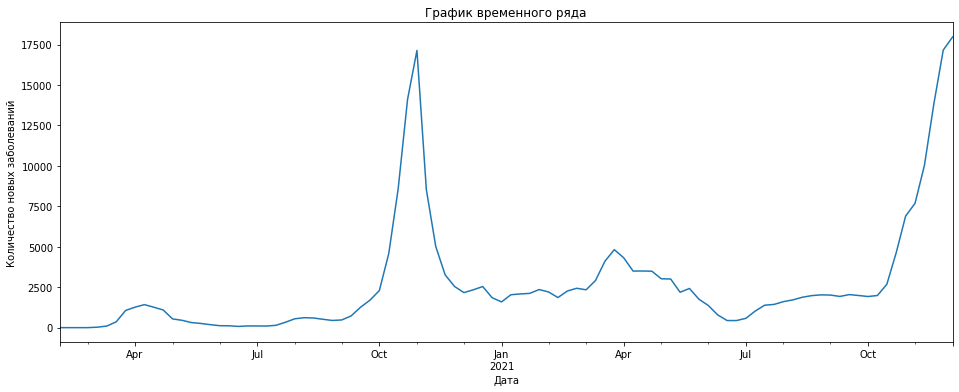

In [5]:
fig = plt.figure(figsize=(16,20))
    
ax0 = fig.add_subplot(311)
ts.plot(ax=ax0)
ax0.set_title('График временного ряда')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

# Определение типа ряда

In [6]:
from statsmodels.tsa.ar_model import AutoReg as Autoreg

In [7]:
import statsmodels.tsa.ar_model

In [8]:
adf_test3(ts)


ШАГ 1

Оцениваем модель авторегрессии 1го порядка с трендом и константой
                            AutoReg Model Results                             
Dep. Variable:              new_cases   No. Observations:                   96
Model:                     AutoReg(1)   Log Likelihood                -824.733
Method:               Conditional MLE   S.D. of innovations           1425.756
Date:                Mon, 27 Dec 2021   AIC                             14.609
Time:                        10:33:43   BIC                             14.717
Sample:                    02-16-2020   HQIC                            14.653
                         - 12-05-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     -219.7536    299.769     -0.733      0.464    -807.290     367.783
trend            9.1225      5.776      1.579      

# Определение порядка разности d и компонент p, q.

### График временного ряда, АКФ и ЧАКФ

Критерий Дики-Фуллера: p=0.600295
Ряд нестационарен, нужно большее d
Критерий Дики-Фуллера с константой: p=0.600295
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=0.192744
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.899869
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.523516
Ряд нестационарен


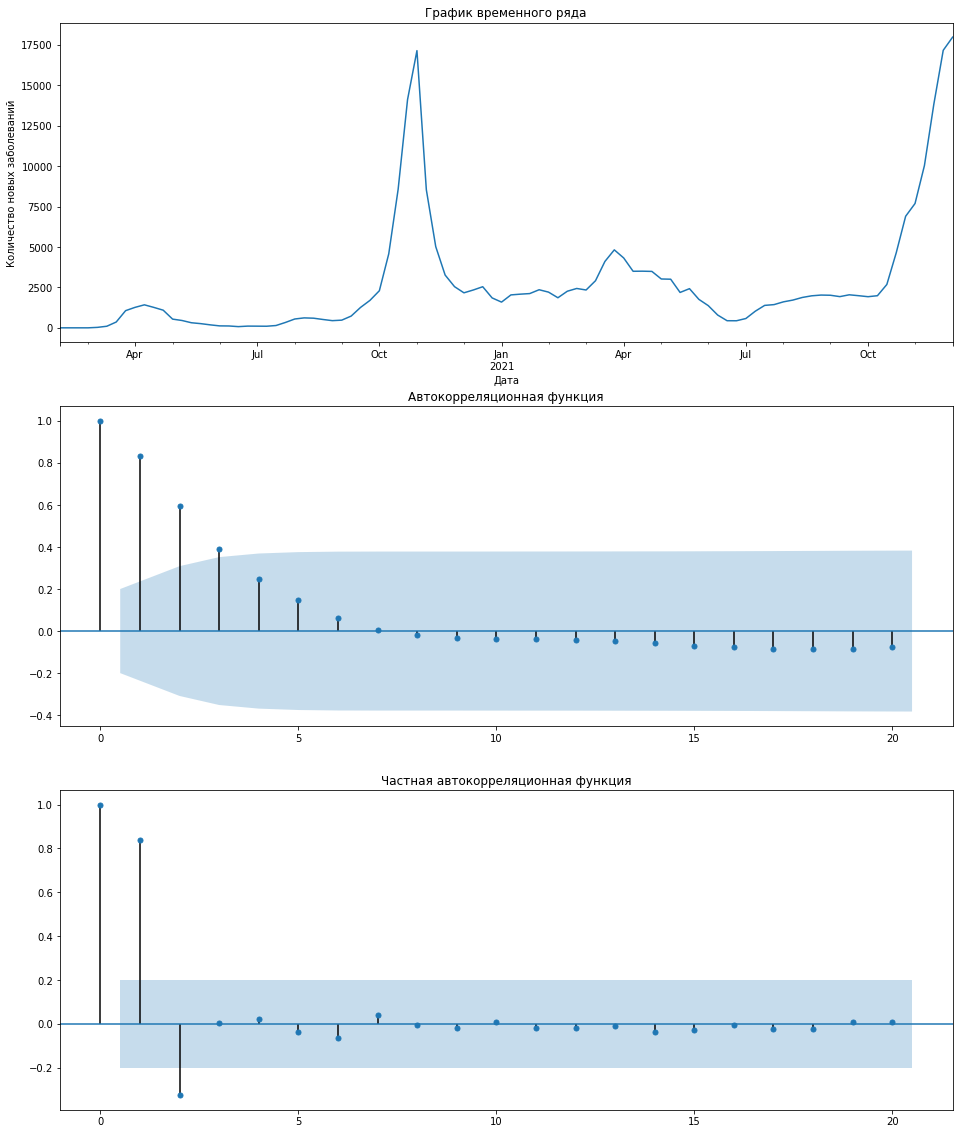

In [9]:
adf_test(ts)
plot_acf_pacf(ts)

### График первых разностей

Критерий Дики-Фуллера: p=0.000000
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.000000
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000001
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.000001
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000000
Ряд стационарен


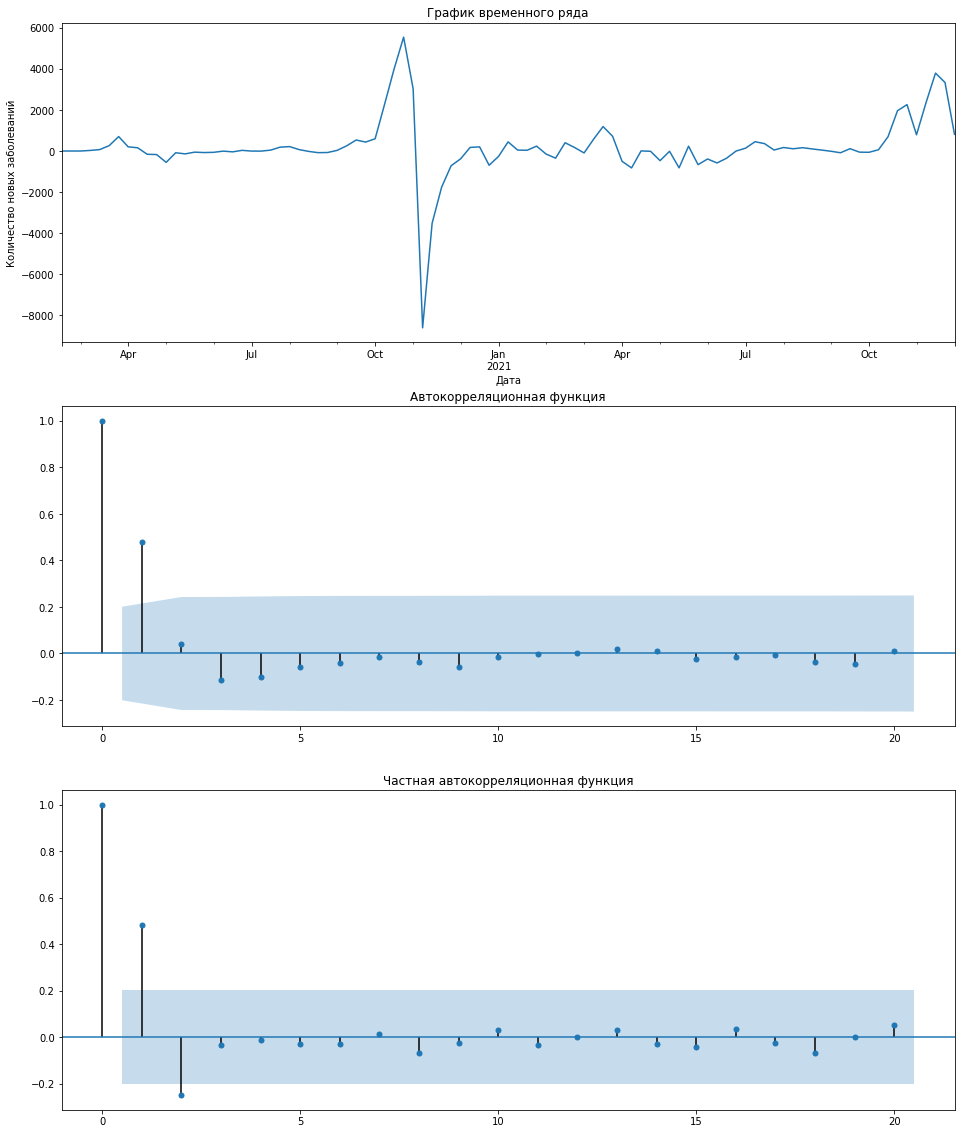

In [10]:
dif_1 = ts.diff().dropna()
adf_test(dif_1)
plot_acf_pacf(dif_1)

### График вторых разностей

Критерий Дики-Фуллера: p=0.000000
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.000000
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000000
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.000002
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000000
Ряд стационарен


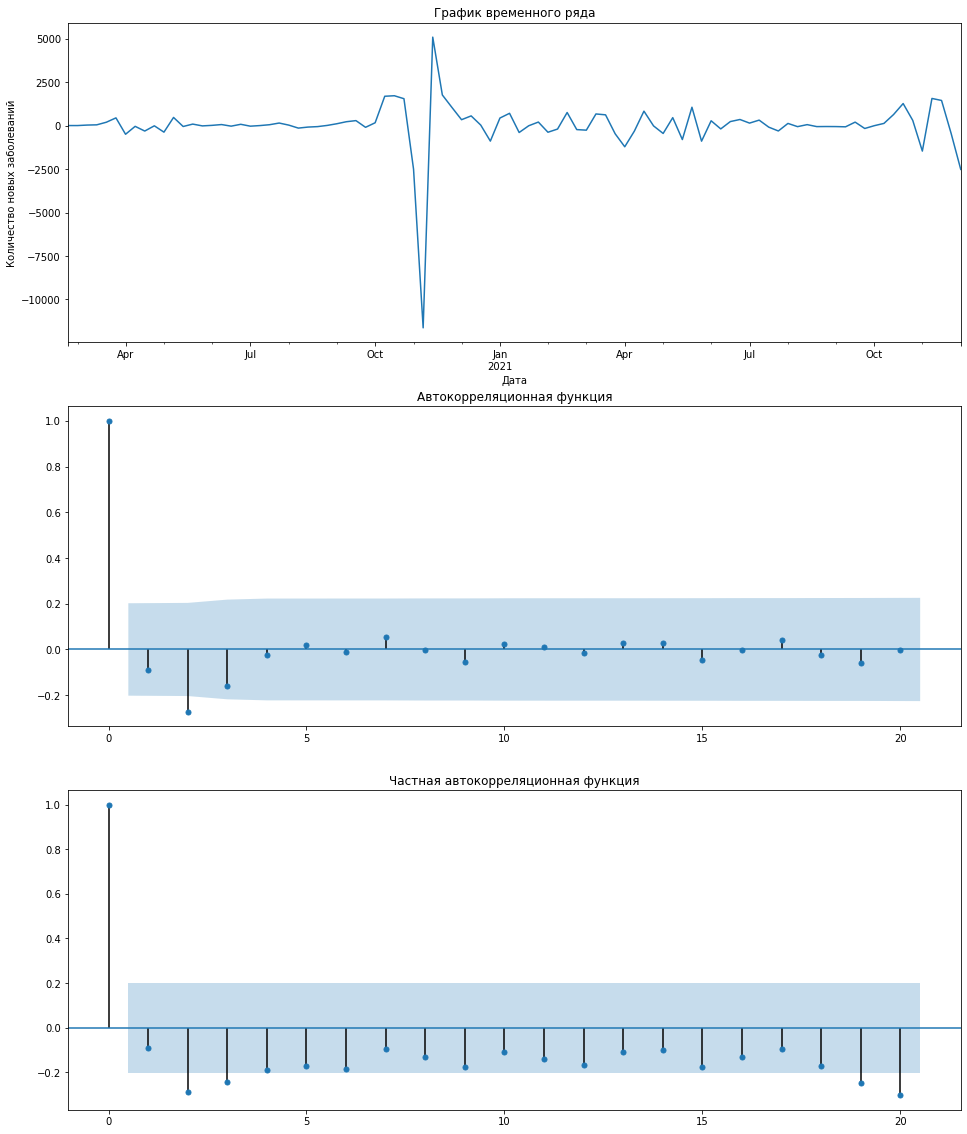

In [11]:
dif_2 = ts.diff().diff().dropna()
adf_test(dif_2)
plot_acf_pacf(dif_2)

### p и q определяются по графикам АКФ и ЧАКФ для подходящего значения d

# Оценка параметров моделей

* Log Lokehood - логарифм правдоподобия
* S.D. of inovations - стандартная ошибка модели
* AIC - информационный критерий Аккаике
* BIC - информационный критерий Байеса
* HQIC - информационный критерий Хеннана-Куинна
* coef - значение коэффициента
* P>|z| - p-value для гипотезы о незначимости коэффициента (если больше 0.05 - незначим)

# Поиск 5 лучших моделей: перебор параметров

In [12]:
d = range(0, 4)
q = range(0, 8)
p = range(0, 8)

from itertools import product

parameters = list(product(p,d,q))
len(parameters)

256

In [13]:
# Может выполняться несколько минут
results = []
best_bic = float("inf")

for param in tqdm(parameters):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.ARIMA(ts, order=param).fit()
    except (ValueError, linalg.LinAlgError):
        continue
    bic = model.bic
    #сохраняем лучшую модель, bic, параметры
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_param = param
    results.append([param, model.bic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'bic']
result_table.sort_values(by = 'bic', ascending=True).head(5)

100%|██████████| 256/256 [02:30<00:00,  1.70it/s]


,parameters,bic
18,"(0, 2, 2)",1629.017094
54,"(2, 2, 1)",1630.846213
19,"(0, 2, 3)",1631.631675
37,"(1, 2, 1)",1631.854209
38,"(1, 2, 2)",1632.128642


### Для начала поработаем с лучшей моделью (можно указать любую модель из 5)

In [13]:
model = sm.tsa.ARIMA(ts, order=(0, 2, 2)).fit() # !!!!!!!!!!!
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.new_cases   No. Observations:                   94
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -805.422
Method:                       css-mle   S.D. of innovations           1246.258
Date:                Mon, 27 Dec 2021   AIC                           1618.844
Time:                        10:34:00   BIC                           1629.017
Sample:                    02-23-2020   HQIC                          1622.953
                         - 12-05-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.1738      6.976      1.172      0.241      -5.500      21.847
ma.L1.D2.new_cases    -0.4878      0.087     -5.577      0.000      -0.659      -0.316
ma.L2.D2.new_cases    -0.5122      0.081     -6.314      0.000      -0.671      -0.353
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.9524           +0.0000j            1.9524            0.5000
-----------------------------------------------------------------------------
"""

---

# Проверка адекватности модели

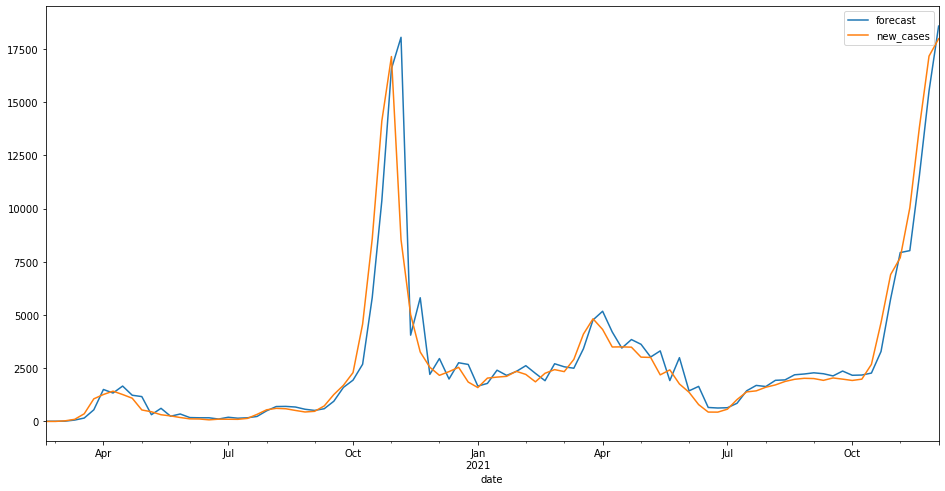

In [14]:
fig, ax = plt.subplots(figsize=(16,8))
model.plot_predict(ax=ax)
#plt.plot(model.predict())
fig.show()

In [16]:
pip show scikit-learn

Name: scikit-learn
Version: 1.0.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Users/antonlukanov/opt/anaconda3/lib/python3.7/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sklearn
Note: you may need to restart the kernel to use updated packages.


In [15]:
pred = model.predict(typ='levels')
print('MSE =', metrics.mean_squared_error(ts[2:], pred))
print('RMSE =', np.sqrt(metrics.mean_squared_error(ts[2:], pred)))
print('MAE =', metrics.mean_absolute_error(ts[2:], pred))
print('MAPE =', metrics.mean_absolute_percentage_error(ts[2:], pred))
print('R2 =', metrics.r2_score(ts[2:], pred))


MSE = 1591258.7025771209
RMSE = 1261.4510305902172
MAE = 554.3270023729111
MAPE = 383625462306074.4
R2 = 0.8843818135888596


# Проверка нормальности остатков

Критерий Дики-Фуллера: p=1.000000
Ряд нестационарен, нужно большее d
Критерий Дики-Фуллера с константой: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.999994
Ряд нестационарен


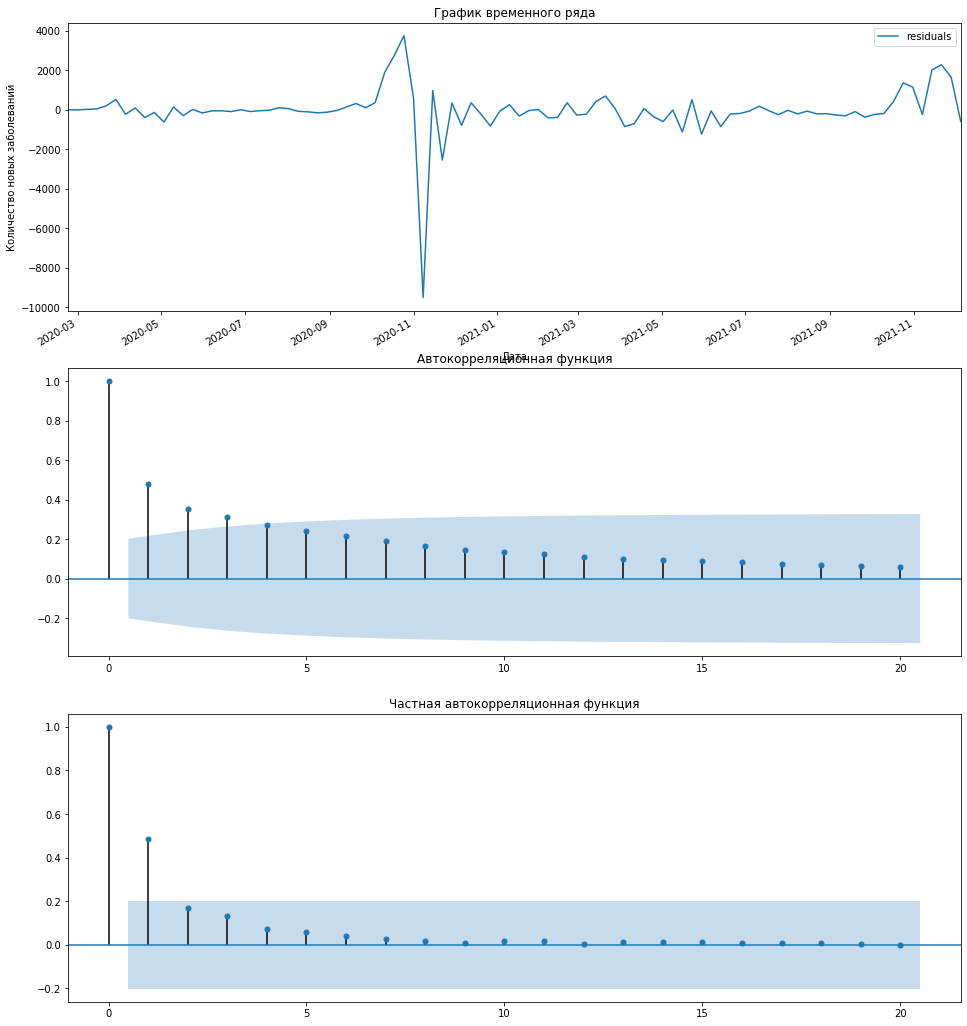

In [16]:
resid = pd.DataFrame(model.resid, columns=['residuals']).sort_values(by='residuals')
adf_test(resid)
plot_acf_pacf(resid)

Тест на нормальность: p = 0.000000
Распределение остатков ненормальное


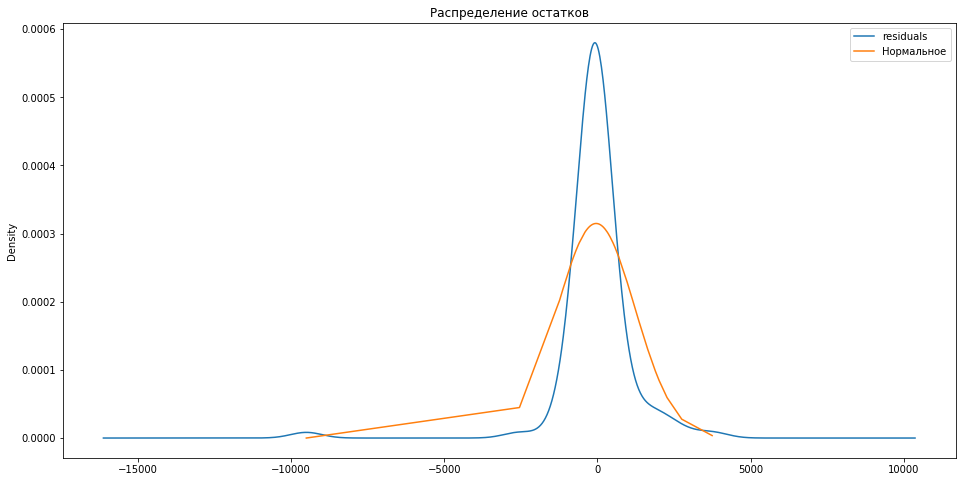

In [17]:
pvalue = sts.normaltest(resid['residuals'])[1]
print("Тест на нормальность: p = %f" % pvalue)
if pvalue > 0.05:
    print("Распределение остатков нормальное")
else:
    print("Распределение остатков ненормальное")

fig, ax = plt.subplots(figsize=(16,8))
resid.plot.kde(ax=ax)
plt.title('Распределение остатков')
plt.plot(resid, sts.norm.pdf(resid, resid.mean(), resid.std()), label='Нормальное')
plt.legend()
fig.show()

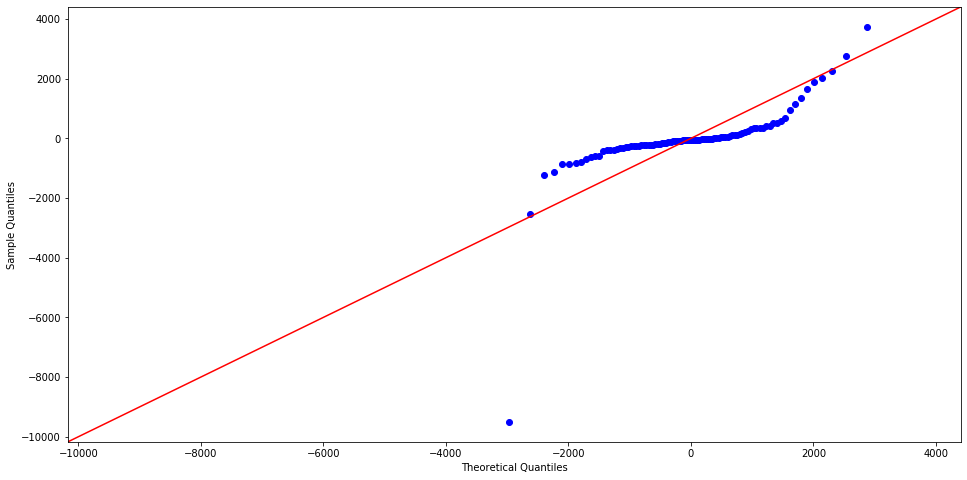

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
sm.qqplot(resid['residuals'], loc=resid['residuals'].mean(), scale = resid['residuals'].std(), line='45', ax=ax)
fig.show()

# Предсказание будущих показателей

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.new_cases   No. Observations:                   94
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -805.422
Method:                       css-mle   S.D. of innovations           1246.258
Date:                Mon, 27 Dec 2021   AIC                           1618.844
Time:                        10:34:17   BIC                           1629.017
Sample:                    02-23-2020   HQIC                          1622.953
                         - 12-05-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.1738      6.976      1.172      0.241      -5.500      21.847
ma.L1.D2.new_cases    -0.4878      0.087     -5.577      0.000      -0.659      -0.316
ma.L2.D2.new_cases    -0.5122      0.081     -6.314      0.000      -0.671      -0.353
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.9524           +0.0000j            1.9524            0.5000
-----------------------------------------------------------------------------
"""

Последняя дата во временном ряду:  2021-12-05 00:00:00
Предсказание на 2 недели, до: 2021-12-19 00:00:00


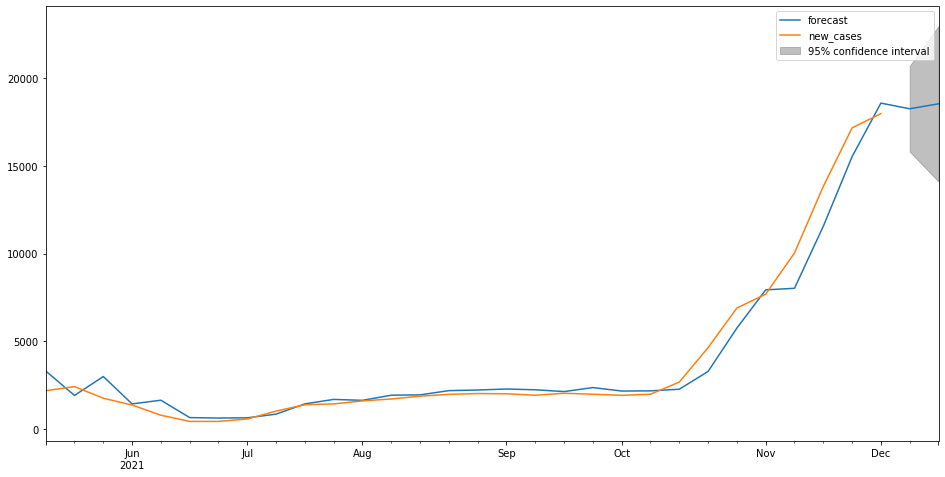

In [20]:
weeks_pred = 2 # количество недель для предсказания !!!!!!!!!!!!!

print("Последняя дата во временном ряду: ", ts.index[-1])
print(f"Предсказание на {weeks_pred} недели, до: {ts.index[-1] + timedelta(weeks=weeks_pred)}")

fig, ax = plt.subplots(figsize=(16,8))
model.plot_predict(start=ts.index[-30], end=(ts.index[-1] + timedelta(weeks=weeks_pred)), ax=ax)
fig.show()

Последняя дата во временном ряду:  2021-12-05 00:00:00
Предсказание на 2 недели, до: 2021-12-19 00:00:00


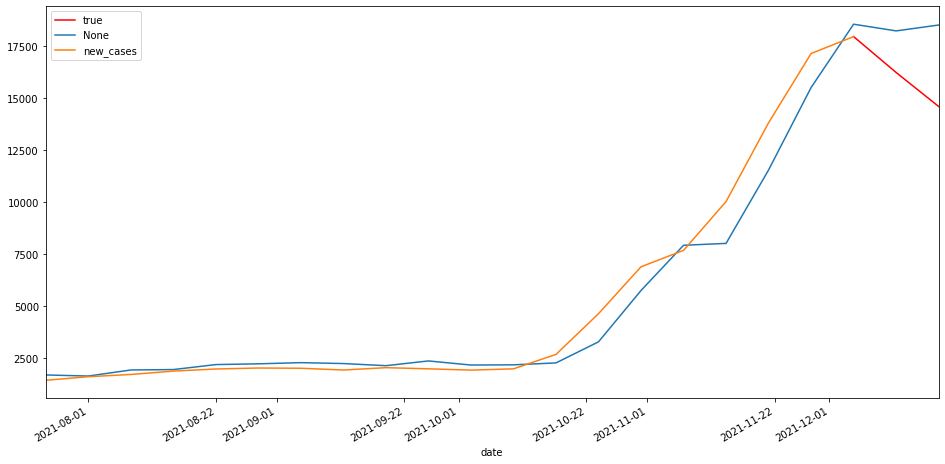

In [28]:
prds=[ts[-1],16250,14615]
weeks_pred = 2 # количество недель для предсказания !!!!!!!!!!!!!

print("Последняя дата во временном ряду: ", ts.index[-1])
print(f"Предсказание на {weeks_pred} недели, до: {ts.index[-1] + timedelta(weeks=weeks_pred)}")

fig, ax = plt.subplots(figsize=(16,8))
pred = model.predict(start=ts.index[-20], end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
plt.plot([ts.index[-1],ts.index[-1] + timedelta(weeks=1),ts.index[-1] + timedelta(weeks=2)],prds,c='r',label='true')
pred.plot(ax=ax)
ts[-20:].plot(ax=ax)
plt.legend()
fig.show()

In [23]:
pred = model.predict(start=ts.index[-1] + timedelta(days=1), end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred

2021-12-12    18250.558332
2021-12-19    18533.004720
Freq: W-SUN, dtype: float64

# Соберем ансамбль предсказаний

In [65]:
result_table.sort_values(by = 'bic', ascending=True).head(5)

,parameters,bic
18,"(0, 2, 2)",1629.017094
54,"(2, 2, 1)",1630.846213
19,"(0, 2, 3)",1631.631675
37,"(1, 2, 1)",1631.854209
38,"(1, 2, 2)",1632.128642


## Меняем параметры моделей на табличные

In [42]:
model1 = sm.tsa.ARIMA(ts, order=(1, 2, 1)).fit()
model2 = sm.tsa.ARIMA(ts, order=(0, 2, 4)).fit()
model3 = sm.tsa.ARIMA(ts, order=(0, 2, 5)).fit()
model4 = sm.tsa.ARIMA(ts, order=(0, 2, 2)).fit()
model5 = sm.tsa.ARIMA(ts, order=(0, 2, 1)).fit()

## Сохраняем предсказания ансамбля и доверительные интервалы в Excel-файл

In [43]:
forecast = pd.DataFrame(index=pred.index)
res1 = model1.forecast(weeks_pred)
res2 = model2.forecast(weeks_pred)
res3 = model3.forecast(weeks_pred)
res4 = model4.forecast(weeks_pred)
res5 = model5.forecast(weeks_pred)
forecast['value1'] = res1[0]
forecast['value2'] = res2[0]
forecast['value3'] = res3[0]
forecast['value4'] = res4[0]
forecast['value5'] = res5[0]
forecast['result'] = (forecast['value1']+forecast['value2']+forecast['value3']+forecast['value4']+forecast['value5'])/5
forecast['left_border'] = [x[0] for x in res1[2]]
forecast['right_border'] = [x[1] for x in res1[2]]
forecast.to_excel('forecast.xlsx')
forecast

,value1,value2,value3,value4,value5,result,left_border,right_border
2021-12-12,18693.072715,18228.303675,17902.013038,18250.558332,18567.407658,18328.271084,16206.660682,21179.484748
2021-12-19,19367.694684,18488.399747,17835.445179,18533.004720,19166.953329,18678.299532,14932.672232,23802.717136


# Добавим сезонность и построим SARIMA

Общий вид модели - **SARIMA (p,d,q) (P,D,Q) s**

* p - порядок модели AR
* d - порядок интегрирования
* q - порядок модели MA
* P - порядок сезонной составляющей SAR
* D - порядок интегрирования сезонной составляющей
* Q - порядок сезонной составляющей SMA
* s - размерность сезонности

### Для начала надо провести сдвиг по сезонности, можно попробовать разные, рекомендуемый 4-6 месяцев.

Сезонная разность:
Критерий Дики-Фуллера: p=0.081505
Ряд нестационарен, нужно большее d
Критерий Дики-Фуллера с константой: p=0.081505
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=0.815643
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.212131
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.013213
Ряд стационарен
------------------------------
Интегрированная сезонная разность:
Критерий Дики-Фуллера: p=0.000001
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.000001
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000006
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.000066
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000000
Ряд стационарен


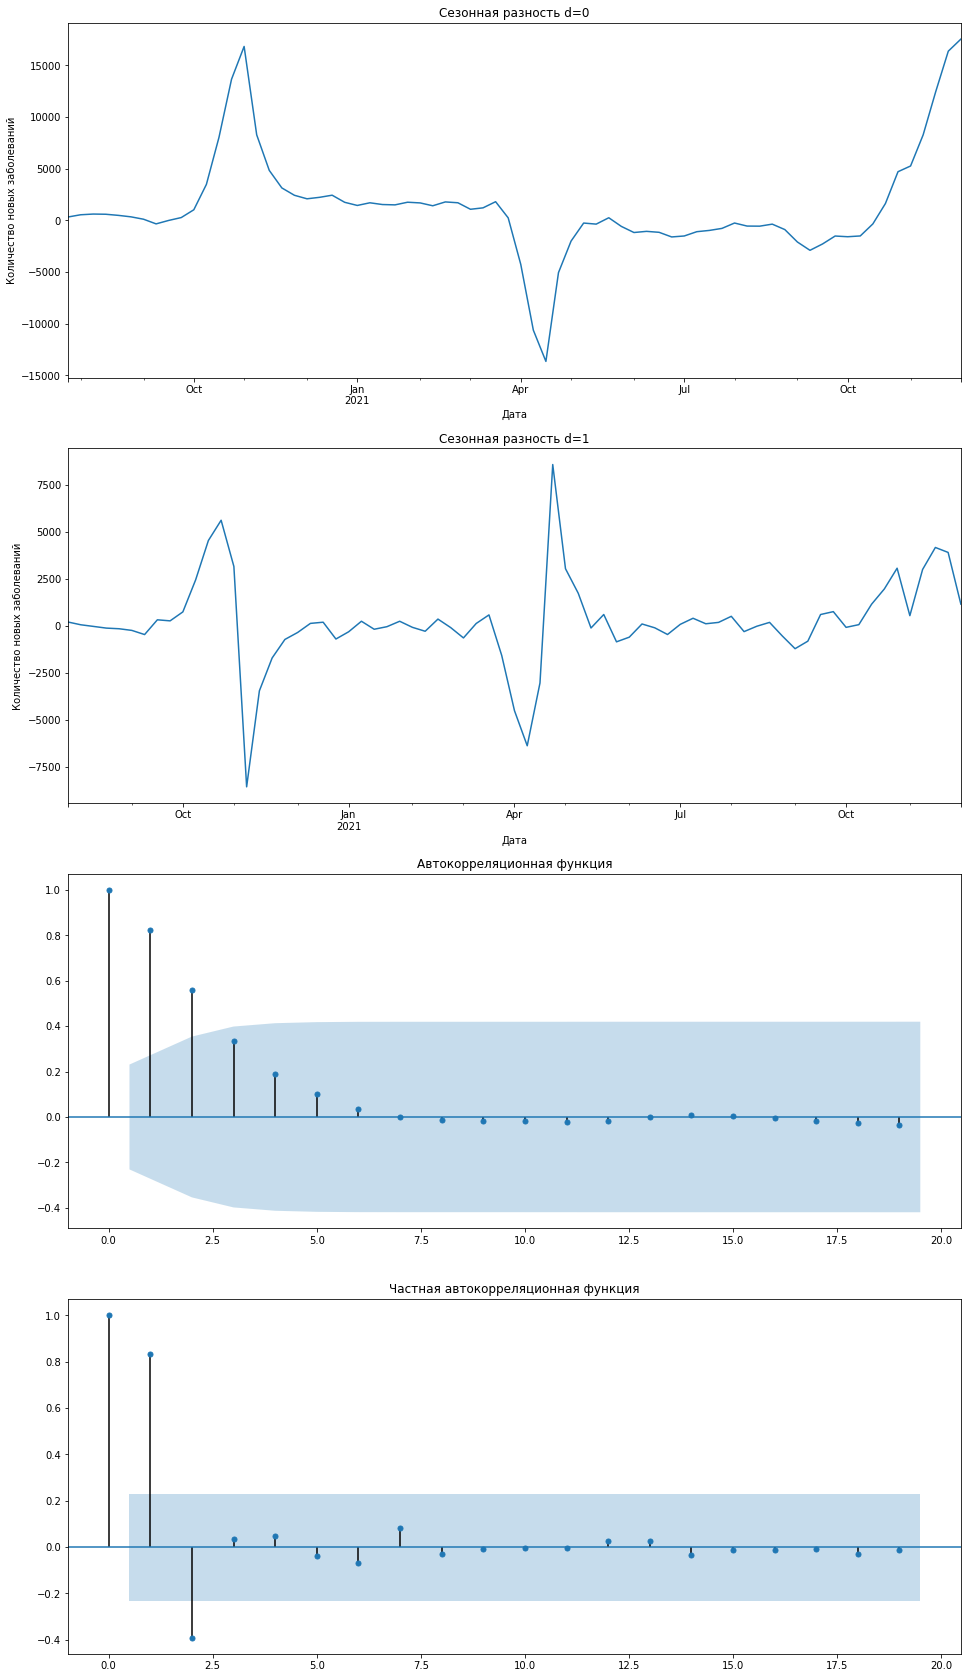

In [24]:
months_seasonal = 6 # !!!!!!!!!!!!


ts_4m = ts.diff(4*months_seasonal).dropna()
print("Сезонная разность:")
adf_test(ts_4m)

print("-"*30)
dif_4m = ts.diff(4*months_seasonal).diff().dropna()
print("Интегрированная сезонная разность:")
adf_test(dif_4m)

# dif2_4m = ts.diff(30*monhts_seasonal).diff().diff().dropna()
# adf_test(dif2_4m)

fig = plt.figure(figsize=(16,30))
    
ax0 = fig.add_subplot(411)
ts_4m.plot(ax=ax0)
ax0.set_title('Сезонная разность d=0')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

ax0 = fig.add_subplot(412)
dif_4m.plot(ax=ax0)
ax0.set_title('Сезонная разность d=1')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

ax1 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_acf(ts_4m, ax=ax1)
ax1.set_title('Автокорреляционная функция')

ax2 = fig.add_subplot(414)
fig = sm.graphics.tsa.plot_pacf(ts_4m, ax=ax2)
ax2.set_title('Частная автокорреляционная функция')

fig.show()

### P и Q определяются по графикам АКФ и ЧАКФ для подходящего значения D сезонной разности

In [25]:
%%time 

#Модель SARIMA может тренироваться долго - если ставить значения параметров больше 1 время растет в геометрической прогресии... 

p = 0
d = 2
q = 2
P = 2
D = 0
Q = 2
s = 4*months_seasonal

sarima = sm.tsa.statespace.SARIMAX(ts, order=(p, d, q), 
                                seasonal_order=(P, D, Q, s)).fit()
print(sarima.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                          new_cases   No. Observations:                   96
Model:             SARIMAX(0, 2, 2)x(2, 0, 2, 24)   Log Likelihood                -805.801
Date:                            Sun, 26 Dec 2021   AIC                           1625.602
Time:                                    21:43:59   BIC                           1643.405
Sample:                                02-09-2020   HQIC                          1632.793
                                     - 12-05-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4686      0.291     -1.612      0.107      -1.038       0.101
ma.L2         -0.5130      0.192   

---

# Проверка адекватности сезонной модели

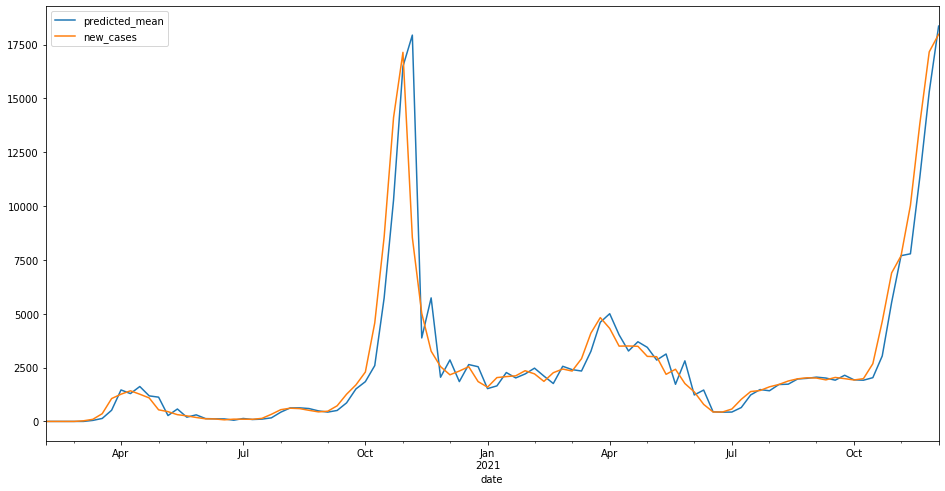

In [26]:
fig, ax = plt.subplots(figsize=(16,8))
pred = sarima.predict(typ='levels')
pred.plot(ax=ax)
ts.plot(ax=ax)
plt.legend()
fig.show()

In [27]:
print('MSE =', metrics.mean_squared_error(ts, pred))
print('RMSE =', np.sqrt(metrics.mean_squared_error(ts, pred)))
print('MAE =', metrics.mean_absolute_error(ts, pred))
print('MAPE =', metrics.mean_absolute_percentage_error(ts, pred))
print('R2 =', metrics.r2_score(ts, pred))

MSE = 1578576.4343519637
RMSE = 1256.4141173800792
MAE = 533.6392353156648
MAPE = 19701141554241.31
R2 = 0.8842147479988087


# Проверка нормальности остатков

Критерий Дики-Фуллера: p=1.000000
Ряд нестационарен, нужно большее d
Критерий Дики-Фуллера с константой: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.999999
Ряд нестационарен


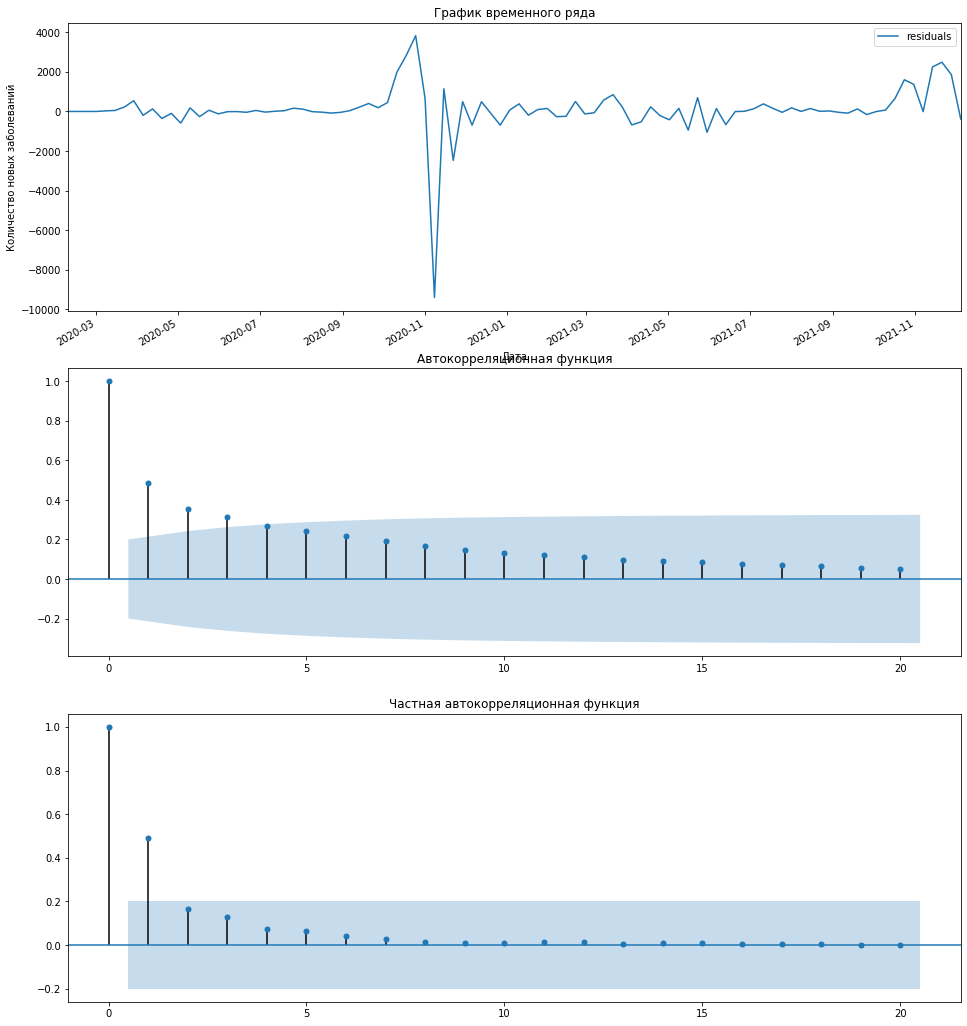

In [28]:
resid = pd.DataFrame(sarima.resid, columns=['residuals']).sort_values(by='residuals')
adf_test(resid)
plot_acf_pacf(resid)

Тест на нормальность: p = 0.000000
Распределение остатков ненормальное


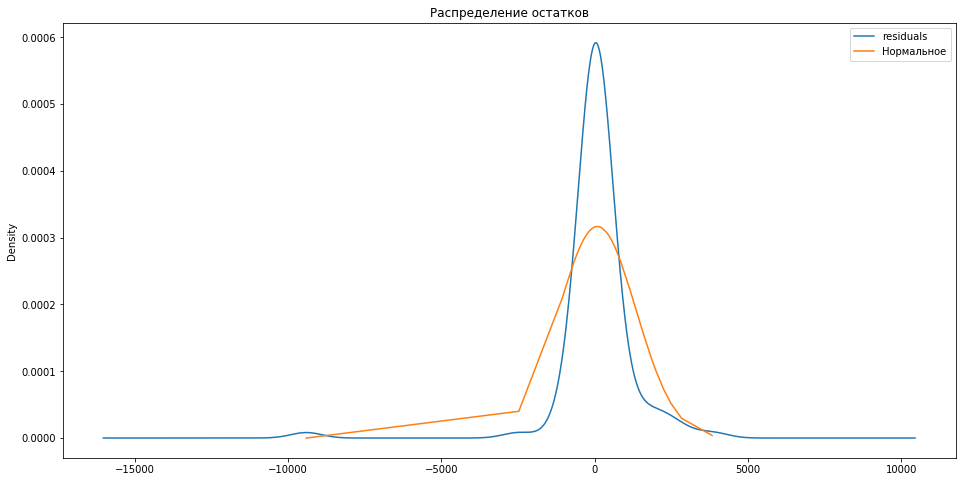

In [29]:
pvalue = sts.normaltest(resid['residuals'])[1]
print("Тест на нормальность: p = %f" % pvalue)
if pvalue > 0.05:
    print("Распределение остатков нормальное")
else:
    print("Распределение остатков ненормальное")

fig, ax = plt.subplots(figsize=(16,8))
resid.plot.kde(ax=ax)
plt.title('Распределение остатков')
plt.plot(resid, sts.norm.pdf(resid, resid.mean(), resid.std()), label='Нормальное')
plt.legend()
fig.show()

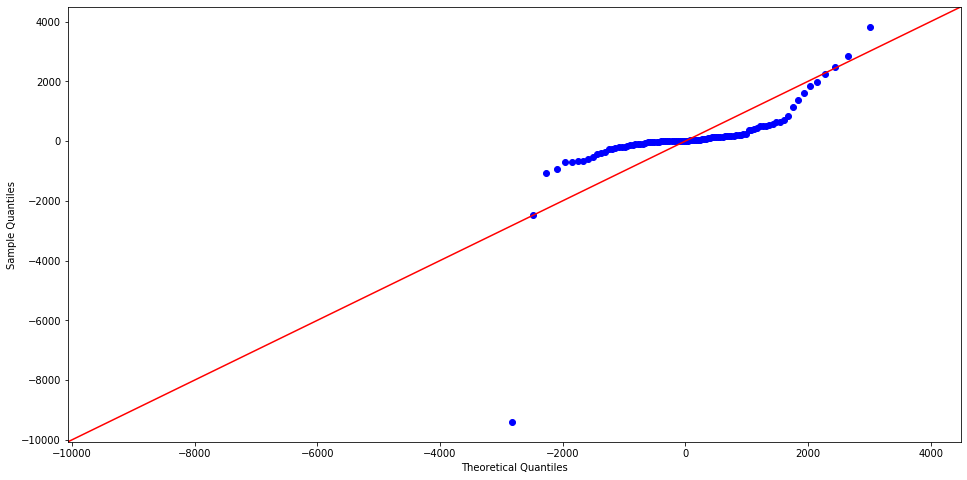

In [30]:
fig, ax = plt.subplots(figsize=(16,8))
sm.qqplot(resid['residuals'], loc=resid['residuals'].mean(), scale = resid['residuals'].std(), line='45', ax=ax)
fig.show()

# Предсказание будущих показателей

In [31]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                   96
Model:             SARIMAX(0, 2, 2)x(2, 0, 2, 24)   Log Likelihood                -805.801
Date:                            Sun, 26 Dec 2021   AIC                           1625.602
Time:                                    21:44:00   BIC                           1643.405
Sample:                                02-09-2020   HQIC                          1632.793
                                     - 12-05-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4686      0.291     -1.612      0.107      -1.038       0.101
ma.L2         -0.5130      0.192     -2.679      0.007      -0.888      -0.138
ar.S.L24       0.0066      1.778      0.004      0.997      -3.479       3.492
ar.S.L48       0.9934      4.895      0.203      0.839      -8.602      10.588
ma.S.L24      -0.0089      2.096     -0.004      0.997      -4.118       4.100
ma.S.L48      -0.9911      5.122     -0.193      0.847     -11.030       9.047
sigma2      1.602e+06   8.98e-05   1.78e+10      0.000     1.6e+06     1.6e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              4279.51
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):              19.22   Skew:                            -3.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.65e+25. Standard errors may be unstable.
"""

Последняя дата во временном ряду:  2021-12-05 00:00:00
Предсказание на 2 недели, до: 2021-12-19 00:00:00


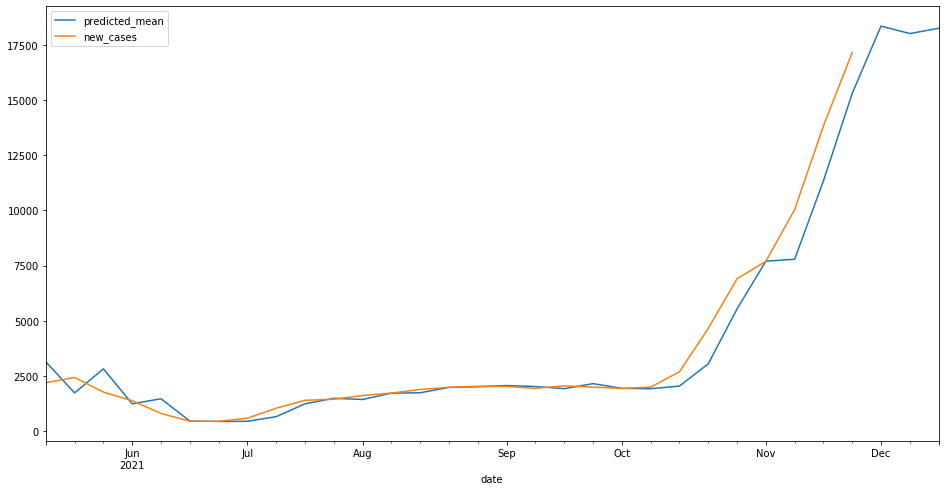

In [32]:
weeks_pred = 2 # количество недель для предсказания !!!!!!!!!!!!!

print("Последняя дата во временном ряду: ", ts.index[-1])
print(f"Предсказание на {weeks_pred} недели, до: {ts.index[-1] + timedelta(weeks=weeks_pred)}")

fig, ax = plt.subplots(figsize=(16,8))
pred = sarima.predict(start=ts.index[-30], end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred.plot(ax=ax)
ts[-30:-1].plot(ax=ax)
plt.legend()
fig.show()

In [53]:
pred = sarima.predict(start=ts.index[-1] + timedelta(days=1), end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred

2021-12-12    18918.373808
2021-12-19    19640.051407
Freq: W-SUN, Name: predicted_mean, dtype: float64

## Сохраняем предсказания и доверительные интервалы в Excel-файл

In [54]:
forecast = pd.DataFrame(columns=['value'], index=pred.index)
res = sarima.forecast(weeks_pred)
forecast['value'] = res
forecast.to_excel('forecast_sarima.xlsx')
forecast

,value
2021-12-12,18918.373808
2021-12-19,19640.051407
